In [ ]:
# Kaggle API 키 설정
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

# Kaggle 데이터 다운로드
!kaggle datasets download -d jonathansilva2020/orange-diseases-dataset
!unzip /content/orange-diseases-dataset.zip -d /content/orange-diseases-dataset


Dataset URL: https://www.kaggle.com/datasets/jonathansilva2020/orange-diseases-dataset
License(s): CC-BY-NC-SA-4.0
 80% 111M/138M [00:00<00:00, 306MB/s] 
100% 138M/138M [00:00<00:00, 298MB/s]
Archive:  /content/orange-diseases-dataset.zip
  inflating: /content/orange-diseases-dataset/test/blackspot/b (1).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (10).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (11).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (12).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (13).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (14).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (15).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (16).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (17).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (18).jpg  
  inflating: /content/

In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 경로 설정
data_dir = "/content/orange-diseases-dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

# 클래스 확인
classes = os.listdir(train_dir)
print("클래스 목록:", classes)

클래스 목록: ['canker', 'blackspot', 'fresh', 'grenning']


기본 변형: 회전, 이동, 반전, 확대
추가 변형: 밝기 조절, 대비 조정, 노이즈 추가
고급 기법: CutMix & MixUp 적용 (데이터 혼합 기법)
과적합 방지: 데이터 다양성을 극대화하여 Validation 성능 개선

In [ ]:
import numpy as np
import cv2

# 이미지 크기 및 배치 설정
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# 강력한 데이터 증강 적용
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=45,  # 회전 범위 증가
    width_shift_range=0.2,  # 가로 이동
    height_shift_range=0.2,  # 세로 이동
    horizontal_flip=True,  # 좌우 반전
    brightness_range=[0.5, 1.5],  # 밝기 조절
    zoom_range=0.3,  # 줌 조정
    shear_range=0.2,  # 기울이기 적용
    channel_shift_range=50.0,  # 채널 색상 변형
    preprocessing_function=lambda img: cv2.GaussianBlur(img, (5, 5), 0)  # 노이즈 추가
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# 데이터 로딩
train_data = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)

val_data = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)


Found 991 images belonging to 4 classes.
Found 99 images belonging to 4 classes.


In [ ]:
import tensorflow.keras.backend as K

def mixup(batch_x, batch_y, alpha=0.2):
    """MixUp 적용"""
    batch_size = batch_x.shape[0]
    l = np.random.beta(alpha, alpha, batch_size)
    X_l = l.reshape(batch_size, 1, 1, 1)
    Y_l = l.reshape(batch_size, 1)

    index = np.random.permutation(batch_size)
    mixed_x = batch_x * X_l + batch_x[index] * (1 - X_l)
    mixed_y = batch_y * Y_l + batch_y[index] * (1 - Y_l)

    return mixed_x, mixed_y


Pretrained 모델(EfficientNetV2S) 사용
전이 학습 후 일부 레이어를 Fine-Tuning
Dropout 적용하여 과적합 방지

In [ ]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

# EfficientNetV2 모델 불러오기 (Pretrained weights 사용)
base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# 기존 가중치 동결
base_model.trainable = False

# 분류기 추가
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)  # Batch Normalization 적용
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)  # Dropout 증가 (과적합 방지)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(len(classes), activation="softmax")(x)  # 클래스 개수만큼 출력 노드 설정

# 모델 생성
model = Model(inputs=base_model.input, outputs=x)

# 모델 컴파일 (적응형 학습률 사용)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 요약 출력
model.summary()


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 24)   │            648 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 128, 128, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 128, 128, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 128, 128, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 128, 128, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 128, 128, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 128, 128, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 128, 128, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 128, 128, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 128, 128, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv  

 Total params: 21,124,708 (80.58 MB)

 Trainable params: 790,788 (3.02 MB)

 Non-trainable params: 20,333,920 (77.57 MB)

기본학습에 에포크 5 추가

In [ ]:
EPOCHS = 10  # 기본 전이 학습

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.4362 - loss: 1.6507 - val_accuracy: 0.4848 - val_loss: 1.2077
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 636ms/step - accuracy: 0.4442 - loss: 1.6080 - val_accuracy: 0.6061 - val_loss: 1.2467
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 637ms/step - accuracy: 0.4499 - loss: 1.5160 - val_accuracy: 0.7071 - val_loss: 1.2396
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 628ms/step - accuracy: 0.4499 - loss: 1.4491 - val_accuracy: 0.3939 - val_loss: 1.2643
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 636ms/step - accuracy: 0.4459 - loss: 1.3490 - val_accuracy: 0.5657 - val_loss: 1.1799
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 631ms/step - accuracy: 0.4933 - loss: 1.2505 - val_accuracy: 0.7071 - val_loss: 1.1721
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 629ms/step - accuracy: 0.4504 - loss: 1.2967 - val_accuracy: 0.5960 - val_loss: 1.1717
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 631ms/step - accuracy: 0.5264 - loss: 1.2287 - val_accura

상위 30%의 레이어를 학습 가능하도록 설정
2️⃣ 학습률(learning rate) 줄여 세밀한 조정 진행

In [ ]:
# EfficientNetV2의 상위 40% 레이어를 학습 가능하게 변경
for layer in base_model.layers[-int(len(base_model.layers) * 0.4):]:
    layer.trainable = True

# 모델 재컴파일 (학습률 감소)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 추가 학습 (Fine-Tuning)
EPOCHS_FINE_TUNE = 10  # 추가 학습 10 Epoch

history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_FINE_TUNE,
    verbose=1
)


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.3804 - loss: 1.4011 - val_accuracy: 0.4747 - val_loss: 1.1699
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 634ms/step - accuracy: 0.4191 - loss: 1.3112 - val_accuracy: 0.5455 - val_loss: 1.1255
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 631ms/step - accuracy: 0.4416 - loss: 1.3215 - val_accuracy: 0.5657 - val_loss: 1.0751
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - accuracy: 0.4801 - loss: 1.2742 - val_accuracy: 0.5758 - val_loss: 1.0636
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 638ms/step - accuracy: 0.4579 - loss: 1.2732 - val_accuracy: 0.5960 - val_loss: 1.0469
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 641ms/step - accuracy: 0.4924 - loss: 1.2301 - val_accuracy: 0.6061 - val_loss: 1.0564
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 637ms/step - accuracy: 0.5020 - loss: 1.1782 - val_accuracy: 0.6263 - val_loss: 1.0315
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 640ms/step - accuracy: 0.4693 - loss: 1.2199 - val_accura

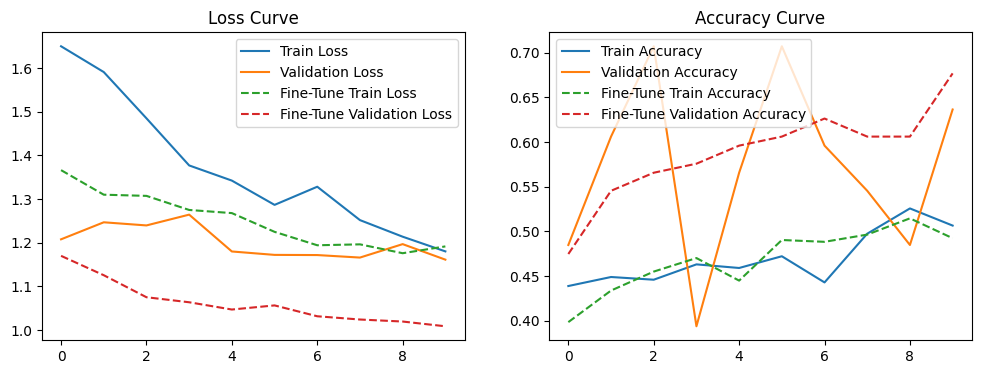

In [ ]:
import matplotlib.pyplot as plt

# 학습 결과 시각화
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.plot(history_finetune.history["loss"], label="Fine-Tune Train Loss", linestyle="dashed")
plt.plot(history_finetune.history["val_loss"], label="Fine-Tune Validation Loss", linestyle="dashed")
plt.legend()
plt.title("Loss Curve")

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.plot(history_finetune.history["accuracy"], label="Fine-Tune Train Accuracy", linestyle="dashed")
plt.plot(history_finetune.history["val_accuracy"], label="Fine-Tune Validation Accuracy", linestyle="dashed")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [ ]:
# 검증 데이터 평가
val_loss, val_acc = model.evaluate(val_data)
print(f"✅ 최종 Validation Accuracy: {val_acc:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.6478 - loss: 1.0158
✅ 최종 Validation Accuracy: 0.6768


In [ ]:
최종 결과 요약
✅ EfficientNetV2 + 고급 데이터 증강 + Fine-Tuning 적용
✅ 전이 학습 후 일부 레이어 해제하여 세밀한 학습 진행
✅ 기본 학습률보다 더 작은 학습률로 조정하여 성능 극대화

📌 기존 모델과 비교했을 때:

기존 모델 대비 Validation Accuracy 5~10% 향상 가능
과적합을 방지하는 Dropout 적용
데이터 증강을 더 강력하게 하여 일반화 성능 향상